## **Install packages**

In [ ]:
!pip install tensorflow
!pip install opencv-python
!pip install pandas

## **Import librairies**


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Data Prepocessing**



In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Set dataset path
dataset_path = '/content/drive/My Drive/ML_Med_Prac2/'

# Load CSV
annotations_df = pd.read_csv(f'{dataset_path}training_set_pixel_size_and_HC.csv')

# Define a function to load and process an image
def load_and_resize_image(filename):
    image_path = os.path.join(dataset_path, 'training_set', filename)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        return cv2.resize(img, (800, 540))
    else:
        print(f"Failed to load image: {image_path}")
        return None

# Apply function to all filenames in the dataframe
images = [load_and_resize_image(filename) for filename in annotations_df['filename']]
images = [img for img in images if img is not None]

if not images:
    print("No images were loaded. Check file paths and names.")
else:
    # Convert list of images to a numpy array and preprocess
    images = np.array(images, dtype='float32').reshape(-1, 800, 540, 1) / 255.0
    hcs = annotations_df['head circumference (mm)'].values.astype('float32')

    # Splitting dataset
    train_images, val_images, train_hcs, val_hcs = train_test_split(images, hcs, test_size=0.2, random_state=42)

    print(f"Successfully loaded and split {len(images)} images.")
    print(f"Train set images: {len(train_images)}, Validation set images: {len(val_images)}")



Successfully loaded and split 999 images.
Train set images: 799, Validation set images: 200


## **Build Model**


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model(input_shape):
    model = Sequential()
    
    # Define the Convolutional Base
    conv_layers = [
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
    ]
    
    # Define the Classifier Head
    classifier_head = [
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(1)
    ]
    
    # Add all layers to the model
    for layer in conv_layers + classifier_head:
        model.add(layer)
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

## **Compiling the model**

In [ ]:
input_shape = (540, 800, 1)
model = build_model(input_shape)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae'])

## **Train the model**

In [ ]:
history = model.fit(train_images, train_hcs,
                    validation_data=(val_images, val_hcs),
                    epochs=10, batch_size=32)

Epoch 1/10
25/25 [==============================] - 420s 17s/step - loss: 7670.4570 - mae: 67.6236 - val_loss: 2377.1650 - val_mae: 38.5890
Epoch 2/10
25/25 [==============================] - 416s 17s/step - loss: 3288.3386 - mae: 44.9659 - val_loss: 2183.9814 - val_mae: 38.4541
Epoch 3/10
25/25 [==============================] - 418s 17s/step - loss: 2754.2559 - mae: 39.8586 - val_loss: 1556.9196 - val_mae: 31.1948
Epoch 4/10
25/25 [==============================] - 422s 17s/step - loss: 2514.2881 - mae: 38.0294 - val_loss: 1508.8600 - val_mae: 31.2127
Epoch 5/10
25/25 [==============================] - 409s 16s/step - loss: 2193.0212 - mae: 36.5121 - val_loss: 1498.5490 - val_mae: 30.2621
Epoch 6/10
25/25 [==============================] - 420s 17s/step - loss: 1959.0596 - mae: 34.7682 - val_loss: 1344.9358 - val_mae: 27.9332
Epoch 7/10
25/25 [==============================] - 420s 17s/step - loss: 1804.5278 - mae: 33.5237 - val_loss: 1257.2206 - val_mae: 27.1136
Epoch 8/10
25/25 [==

## **Evaluate the model**

In [ ]:
val_loss, val_mae = model.evaluate(val_images, val_hcs)
print(f"Validation MAE: {val_mae}")

7/7 [==============================] - 24s 3s/step - loss: 1220.9517 - mae: 27.2775
Validation MAE: 27.277503967285156


## **Visualization**


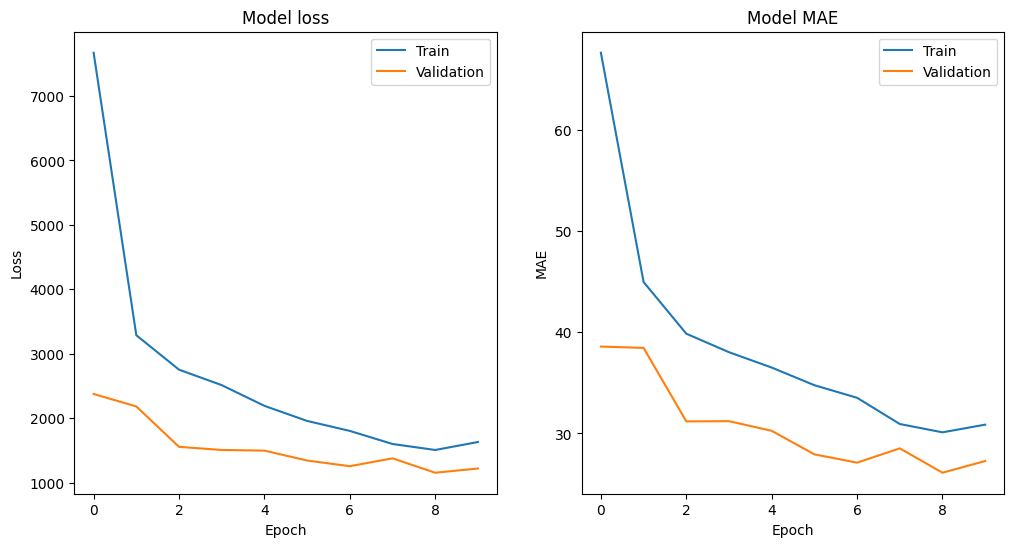

In [ ]:
#Visualize Training Loss and MAE**

import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

plt.show()


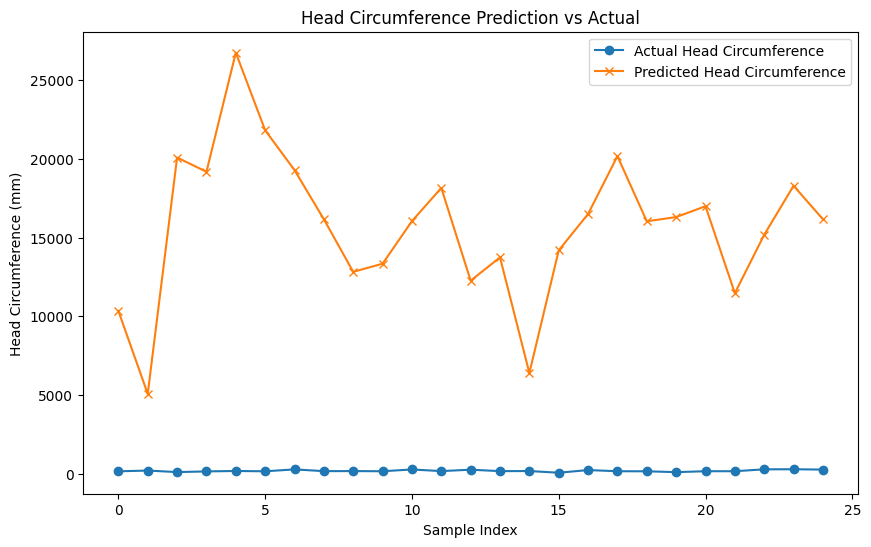

Number of predictions: 82


In [ ]:
# Prediction vs. Ground Truth Visualization**

predictions = predictions.flatten()

# Visualize
N = 25
plt.figure(figsize=(10, 6))
plt.plot(range(N), val_hcs[:N], label='Actual Head Circumference', marker='o')
plt.plot(range(N), predictions[:N], label='Predicted Head Circumference', marker='x')
plt.title('Head Circumference Prediction vs Actual')
plt.xlabel('Sample Index')
plt.ylabel('Head Circumference (mm)')
plt.legend()
plt.show()

print(f"Number of predictions: {len(predictions)}")


In [ ]:
# Adjust val_hcs
val_hcs_corrected = val_hcs[:len(predictions)]

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(val_hcs_corrected, predictions)
print(f"Mean Absolute Error (MAE): {mae:.2f} mm")

Mean Absolute Error (MAE): 15792.51 mm


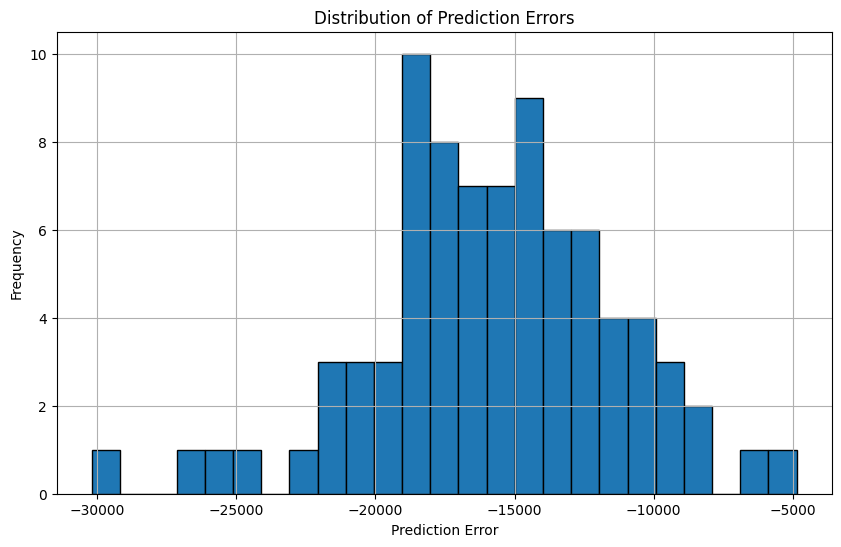

In [ ]:
# Error distribution**

val_hcs_corrected = val_hcs[:len(predictions)]

# Calculate prediction errors
errors = val_hcs_corrected - predictions.flatten()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=25, edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

